In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

# Directories to Images

In [3]:
positive_dir = Path('/kaggle/input/surface-crack-detection/Positive')
negative_dir = Path('/kaggle/input/surface-crack-detection/Negative') 

# Creating DataFrames

In [4]:
list(positive_dir.glob(r'*.jpg'))

[PosixPath('/kaggle/input/surface-crack-detection/Positive/08450.jpg'),
 PosixPath('/kaggle/input/surface-crack-detection/Positive/19812.jpg'),
 PosixPath('/kaggle/input/surface-crack-detection/Positive/05938.jpg'),
 PosixPath('/kaggle/input/surface-crack-detection/Positive/06122.jpg'),
 PosixPath('/kaggle/input/surface-crack-detection/Positive/08536.jpg'),
 PosixPath('/kaggle/input/surface-crack-detection/Positive/04168.jpg'),
 PosixPath('/kaggle/input/surface-crack-detection/Positive/12903_1.jpg'),
 PosixPath('/kaggle/input/surface-crack-detection/Positive/11742_1.jpg'),
 PosixPath('/kaggle/input/surface-crack-detection/Positive/02371.jpg'),
 PosixPath('/kaggle/input/surface-crack-detection/Positive/04377.jpg'),
 PosixPath('/kaggle/input/surface-crack-detection/Positive/14986_1.jpg'),
 PosixPath('/kaggle/input/surface-crack-detection/Positive/09924.jpg'),
 PosixPath('/kaggle/input/surface-crack-detection/Positive/16306_1.jpg'),
 PosixPath('/kaggle/input/surface-crack-detection/Positi

# Dataframe Function

In [5]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name = 'Filepath').astype(str)
    labels = pd.Series(label, name = 'label', index = filepaths.index)

    #Combining filepaths and labels dataframes
    df = pd.concat([filepaths, labels], axis = 1)
    return df

In [6]:
positive_df = generate_df(positive_dir, label = 'POSITIVE')
negative_df =  generate_df(negative_dir, label = 'NEGATIVE')

#Create a dataframe that is a combination of both positive and negative dataframes
all_df = pd.concat([positive_df, negative_df], axis = 0).sample(frac = 1.0, random_state = 1).reset_index(drop = True)
all_df

,Filepath,label
0,/kaggle/input/surface-crack-detection/Positive...,POSITIVE
1,/kaggle/input/surface-crack-detection/Positive...,POSITIVE
2,/kaggle/input/surface-crack-detection/Positive...,POSITIVE
3,/kaggle/input/surface-crack-detection/Negative...,NEGATIVE
4,/kaggle/input/surface-crack-detection/Positive...,POSITIVE
...,...,...
39995,/kaggle/input/surface-crack-detection/Positive...,POSITIVE
39996,/kaggle/input/surface-crack-detection/Negative...,NEGATIVE
39997,/kaggle/input/surface-crack-detection/Positive...,POSITIVE
39998,/kaggle/input/surface-crack-detection/Positive...,POSITIVE


# Splitting data into Training and Test sets

In [7]:
train_df, test_df = train_test_split(
    all_df, 
    train_size = 0.7,
    shuffle = True,
    random_state = 1
)

# Loading Image Data

In [8]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,   #Maximum value is 255, dividing by 255 converts values to a range between 0 and 1 to improve model performance
    validation_split = 0.2   #Creates a validation set that is 20% of the training set
)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
     rescale = 1./255,
)

In [ ]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col = 'Filepath',            #Tells generator to search for filepaths in 'Filepath' column
    y_col = 'label',               #Tells generator to search for image labels in 'label' column
    target_size = (120, 120),     #Resize every image loaded to 120 pixels wide by 120 pixels high
    color_mode = 'rgb',            #Images will be treated as having three color channels (Red, Green, Blue)
    class_mode = 'binary',
    batch_size = 32,
    subset = 'training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col = 'Filepath',
    y_col = 'label',
    target_size = (120, 120),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = 32,
    subset = 'validation'
)

test_data = test_gen.flow_from_dataframe(
    test_df,
    x_col = 'Filepath',
    y_col = 'label',
    target_size = (120, 120),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = 32
)

Found 22400 validated image filenames belonging to 2 classes.
Found 5600 validated image filenames belonging to 2 classes.


# Defining and Training the Convolutional Neural Network

In [1]:
#Defining Input Layer
inputs = tf.keras.Input(shape = (120, 120, 3))  #Defines the shape of the input samples and the number of colour channels

x = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu')(inputs)  
x = tf.keras.layers.MaxPool2D(pool_size = (2, 2))(x)

x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size = (2, 2))(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

#Defining Output Layer
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

print(model.summary())

NameError: name 'tf' is not defined

In [ ]:
history = model.fit(
    train_data,
    validation_data = val_data,
    epochs = 100,
    callbacks = [            #Functions to run at the start or end of each epoch
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss', 
            patience = 10,       #If val_loss doesn't increase for 3 epochs, training will be halted
            restore_best_weights = True      #Sets the model's weights to that of the epoch that had the lowest loss
        )
    ]
)

Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 129s 184ms/step - accuracy: 0.9806 - loss: 0.0618 - val_accuracy: 0.9834 - val_loss: 0.0744
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 133s 190ms/step - accuracy: 0.9826 - loss: 0.0567 - val_accuracy: 0.9779 - val_loss: 0.0645
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 134s 191ms/step - accuracy: 0.9811 - loss: 0.0624 - val_accuracy: 0.9832 - val_loss: 0.0618
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 144s 194ms/step - accuracy: 0.9840 - loss: 0.0516 - val_accuracy: 0.9807 - val_loss: 0.0614
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 136s 194ms/step - accuracy: 0.9820 - loss: 0.0558 - val_accuracy: 0.9793 - val_loss: 0.0594
Epoch 9/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 135s 193ms/step - accuracy: 0.9819 - loss: 0.0576 - val_accuracy: 0.9814 - val_loss: 0.0589
Epoch 10/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 146s 199ms/step - accuracy: 0.9848 - loss: 0.0521 - val_accuracy: 0.9837 - val_loss: 0.0593
Epoch 11/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 141s 198ms/step - accuracy

In [18]:
fig = px.line(
    history.history,
    y = ['loss', 'val_loss'],
    labels = {'index' : "Epoch", 'value' : "Loss"},
    title = "Training and Validation Loss over Time"
)

fig.show()

NameError: name 'history' is not defined

In [19]:
def evaluate_model(model, test_data):

    results = model.evaluate(test_data)
    loss = results[0]
    accuracy = results[1]

    print('Test Loss: {:.5f}'.format(loss))
    print('Test Accuracy: {:.2f}%'.format(accuracy * 100))

    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names = ['Negative', 'Positive'])

    plt.figure(figsize = (6,6))
    sns.heatmap(cm, annot = True, fmt = 'g', vmin = 0, cmap = 'Blues', cbar = False)
    plt.xticks(ticks = np.arange(2) + 0.5, labels = ['Negative', 'Positive'])
    plt.yticks(ticks = np.arange(2) + 0.5, labels = ['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print('Classification Report:\n---------------------------', clr)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 70s 185ms/step - accuracy: 0.5117 - loss: 0.6946
Test Loss: 0.69492
Test Accuracy: 50.21%
375/375 ━━━━━━━━━━━━━━━━━━━━ 25s 67ms/step


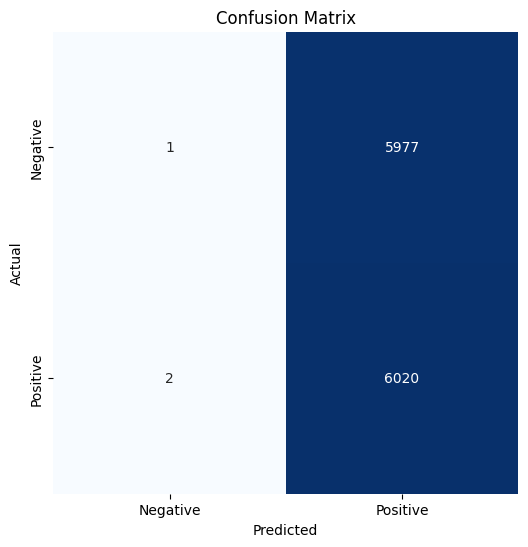

Classification Report:
---------------------------               precision    recall  f1-score   support

    Negative       0.33      0.00      0.00      5978
    Positive       0.50      1.00      0.67      6022

    accuracy                           0.50     12000
   macro avg       0.42      0.50      0.33     12000
weighted avg       0.42      0.50      0.34     12000



In [20]:
evaluate_model(model, test_data)